# ESM-BLSTM Model Runner, Both Binding and Expression at Same Time
### Load in all of the pieces

In [1]:
import os
import re
import sys
import math
import tqdm
import torch
import time
import datetime
import numpy as np
import pandas as pd
from typing import Union
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, EsmModel 
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable

/data/miniconda3/envs/spike_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Since I combined the data into a singular dataset, I updated this to reflect that. I also renamed the binding and expression values to be named more clearly.

In [2]:
# DATASET    
class DMSDataset(Dataset):
    """ Binding or Expression DMS Dataset, not from pickle! """
    
    def __init__(self, csv_file:str):
        """
        Load from csv file into pandas:
        - sequence label ('labels'), 
        - 'sequence',
        - binding target,
        - expression target
        """
        try:
            self.full_df = pd.read_csv(csv_file, sep=',', header=0)
        except (FileNotFoundError, pd.errors.ParserError, Exception) as e:
            print(f"Error reading in .csv file: {csv_file}\n{e}", file=sys.stderr)
            sys.exit(1)

    def __len__(self) -> int:
        return len(self.full_df)

    def __getitem__(self, idx):
        # label, seq, binding target, expression target
        return self.full_df['label'][idx], self.full_df['sequence'][idx], self.full_df['ACE2-binding_affinity'][idx], self.full_df['RBD_expression'][idx]

Some of the helper functions, like the plotting functions, needed to be updated to reflect the added variable.

In [3]:
# HELPER FUNCTIONS
def count_parameters(model):
    """
    Count model parameters and print a summary

    A nice hack from:
    https://stackoverflow.com/a/62508086/1992369
    """
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}\n")
    return total_params

def save_model(model, optimizer, path_to_pth, epoch, loss):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'loss': loss
    }, path_to_pth
    )
    print(f"Model and optimizer state saved to {path_to_pth}")

def load_model_from_trained(model, trained_model_pth, device):
    """ 
    Function to load saved weights from the trained old DMS data  
    ESM-BLSTM transfer learning model. 
    """
    saved_state = torch.load(trained_model_pth, map_location=device)
    model.load_state_dict(saved_state['model_state_dict'])
    epoch = saved_state['epoch']
    loss = saved_state['loss']
    print(f"Loaded trained model from {trained_model_pth}, finished at epoch {epoch}, loss {loss}")
    return model.to(device)

def load_model(model, optimizer, saved_model_pth, device):
    saved_state = torch.load(saved_model_pth, map_location=device)
    model.load_state_dict(saved_state['model_state_dict'])
    optimizer.load_state_dict(saved_state['optimizer_state_dict'])
    epoch = saved_state['epoch']
    loss = saved_state['loss']
    print(f"Loaded model from {saved_model_pth} at epoch {epoch}, loss {loss}")
    return model.to(device), optimizer, epoch, loss

def load_model_checkpoint(path_to_pth, metrics_csv, starting_epoch):
    """ Load model data csv, and model pth. """
    folder_path = os.path.dirname(path_to_pth)
    files_in_folder = os.listdir(folder_path)
    metrics_file_name = [file for file in files_in_folder if file.endswith("_metrics.csv")][0]
    saved_metrics_file = os.path.join(folder_path, metrics_file_name)

    with open(saved_metrics_file, "r") as fa, open(metrics_csv, "w") as fb:
        header = fa.readline()
        fb.write(header)

        for line in fa:
            epoch = int(line.split(',')[0])
            if epoch == starting_epoch:
                break
            fb.write(line)

def plot_log_file(metrics_csv, metrics_img):
    df = pd.read_csv(metrics_csv)

    sns.set_theme(style="darkgrid")

    fontsize = 28
    plt.subplots(figsize=(16, 9))
    plt.plot(df['Epoch'], df['Test RMSE'], label='Test RMSE', color='tab:blue', linewidth=3)
    plt.plot(df['Epoch'], df['Train RMSE'], label='Train RMSE', color='tab:orange', linewidth=3)
    plt.xlabel('Epochs', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    #plt.xlim(-250, 5250)
    plt.ylabel('Loss', fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    #plt.ylim(0.05, 0.79)
    plt.legend(loc='upper right', fontsize=fontsize)
    plt.tight_layout()
    plt.savefig(metrics_img, format='pdf')

def plot_all_log_file(metrics_csv, metrics_img):
    df = pd.read_csv(metrics_csv)

    sns.set_theme(style="darkgrid")

    fontsize = 28
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 18))  # 2 rows, 1 column

    # Plot 1: Training Metrics (binding, expression, combined RMSE)
    ax1.plot(df['Epoch'], df['Train Binding RMSE'], label='Train Binding RMSE', color='tab:blue', linewidth=3)
    ax1.plot(df['Epoch'], df['Train Expression RMSE'], label='Train Expression RMSE', color='tab:green', linewidth=3)
    ax1.plot(df['Epoch'], df['Train RMSE'], label='Train RMSE (Combined)', color='tab:orange', linewidth=3)
    ax1.set_xlabel('Epochs', fontsize=fontsize)
    ax1.set_xticks(range(0, len(df['Epoch']), max(1, len(df['Epoch']) // 10)))
    ax1.tick_params(axis='x', labelsize=fontsize)
    #ax1.set_xlim(-250, 5250)
    ax1.set_ylabel('Loss', fontsize=fontsize)
    ax1.tick_params(axis='y', labelsize=fontsize)
    #ax1.set_ylim(0.05, 0.79)
    ax1.legend(loc='upper right', fontsize=fontsize)
    ax1.set_title('Training Metrics', fontsize=fontsize)

    # Plot 2: Testing Metrics (binding, expression, combined RMSE)
    ax2.plot(df['Epoch'], df['Test Binding RMSE'], label='Test Binding RMSE', color='tab:blue', linewidth=3)
    ax2.plot(df['Epoch'], df['Test Expression RMSE'], label='Test Expression RMSE', color='tab:green', linewidth=3)
    ax2.plot(df['Epoch'], df['Test RMSE'], label='Test RMSE (Combined)', color='tab:orange', linewidth=3)
    ax2.set_xlabel('Epochs', fontsize=fontsize)
    ax2.set_xticks(range(0, len(df['Epoch']), max(1, len(df['Epoch']) // 10)))
    ax2.tick_params(axis='x', labelsize=fontsize)
    #ax2.set_xlim(-250, 5250)
    ax2.set_ylabel('Loss', fontsize=fontsize)
    ax2.tick_params(axis='y', labelsize=fontsize)
    #ax2.set_ylim(0.05, 0.79)
    ax2.legend(loc='upper right', fontsize=fontsize)
    ax2.set_title('Testing Metrics', fontsize=fontsize)

    # Adjust layout and save figure
    plt.tight_layout()
    plt.savefig(metrics_img, format='pdf')
    plt.close()

The functions to run the model also needed to be updated to account for the added variable.

In [4]:
# MODEL RUNNING
def run_model(model, tokenizer, train_data_loader, test_data_loader, n_epochs: int, lr:float, max_batch: Union[int, None], device: str, run_dir: str, save_as: str, saved_model_pth:str=None, from_checkpoint:bool=False):
    """ Run a model through train and test epochs. """

    model = model.to(device)
    loss_fn = nn.MSELoss(reduction='sum').to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr)

    starting_epoch = 1
    best_loss = float('inf')

    # Load saved model if provided
    if saved_model_pth is not None:
        model, optimizer, starting_epoch, best_loss = load_model(model, optimizer, saved_model_pth, device)
        starting_epoch += 1

    start_time = time.time()
    
    metrics_csv = os.path.join(run_dir, f"{save_as}_metrics.csv")
    metrics_img = os.path.join(run_dir, f"{save_as}_metrics.pdf")
    all_metrics_img = os.path.join(run_dir, f"{save_as}_all_metrics.pdf")
    
    # If saved model, skip to predictions 
    # Except when from checkpoint (still need saved model)
    if saved_model_pth is None or (from_checkpoint and saved_model_pth is not None):

        if starting_epoch > n_epochs:
            raise ValueError(f"Starting epoch ({starting_epoch}) is greater than the total number of epochs to run ({n_epochs}). Adjust the number of epochs, 'n_epochs'.")
        
        with open(metrics_csv, "a") as fa:
            if from_checkpoint: load_model_checkpoint(saved_model_pth, metrics_csv, starting_epoch)
            else:
                fa.write((
                    "Epoch,"
                    "Train Binding MSE,Train Binding RMSE,Train Expression MSE,Train Expression RMSE,Train MSE,Train RMSE,"
                    "Test Binding MSE,Test Binding RMSE,Test Expression MSE,Test Expression RMSE,Test MSE,Test RMSE\n"
                ))
                
            for epoch in range(starting_epoch, n_epochs + 1):
                if not max_batch:
                    max_batch = len(train_data_loader)

                train_binding_mse, train_binding_rmse, train_expression_mse, train_expression_rmse, train_mse, train_rmse = epoch_iteration(model, tokenizer, loss_fn, optimizer, train_data_loader, epoch, max_batch, device, mode='train')
                test_binding_mse, test_binding_rmse, test_expression_mse, test_expression_rmse, test_mse, test_rmse = epoch_iteration(model, tokenizer, loss_fn, optimizer, test_data_loader, epoch, max_batch, device, mode='test')

                print(f'Epoch {epoch} | Train Binding MSE: {train_binding_mse:.4f}, Train Expression MSE: {train_expression_mse:.4f}, Train MSE: {train_mse:.4f}') 
                print(f'{" "*(8+len(str(epoch)))} Train Binding RMSE: {train_binding_rmse:.4f}, Train Expression RMSE: {train_expression_rmse:.4f}, Train RMSE: {train_rmse:.4f}') 
                print(f'{" "*(8+len(str(epoch)))} Test Binding MSE: {test_binding_mse:.4f}, Test Expression MSE: {test_expression_mse:.4f}, Test MSE: {test_mse:.4f}') 
                print(f'{" "*(8+len(str(epoch)))} Test Binding RMSE: {test_binding_rmse:.4f}, Test Expression RMSE: {test_expression_rmse:.4f}, Test RMSE: {test_rmse:.4f}') 
                
                fa.write((
                    f"{epoch}," 
                    f"{train_binding_mse}, {train_binding_rmse}, {train_expression_mse}, {train_expression_rmse}, {train_mse}, {train_rmse},"
                    f"{test_binding_mse}, {test_binding_rmse}, {test_expression_mse}, {test_expression_rmse}, {test_mse}, {test_rmse}\n"
                ))                
                fa.flush()

                if test_rmse < best_loss:
                    best_loss = test_rmse
                    model_path = os.path.join(run_dir, f'best_saved_model.pth')
                    print(f"NEW BEST model: loss {best_loss:.4f}")
                    save_model(model, optimizer, model_path, epoch, best_loss)
                
                model_path = os.path.join(run_dir, f'checkpoint_saved_model.pth')
                save_model(model, optimizer, model_path, epoch, test_rmse)
                print("")
        
        plot_log_file(metrics_csv, metrics_img)
        plot_all_log_file(metrics_csv, all_metrics_img)

    # End timer and print duration
    end_time = time.time()
    duration = end_time - start_time
    print(f'Training and testing complete in {duration:.2f} seconds.')

def epoch_iteration(model, tokenizer, loss_fn, optimizer, data_loader, epoch, max_batch, device, mode):
    """ Used in run_model. """
    
    model.train() if mode=='train' else model.eval()

    data_iter = tqdm.tqdm(enumerate(data_loader),
                          desc=f'Epoch_{mode}: {epoch}',
                          total=len(data_loader),
                          bar_format='{l_bar}{r_bar}')

    total_binding_loss, total_expression_loss, total_loss = 0, 0, 0
    total_items = 0

    for batch, batch_data in data_iter:
        if max_batch > 0 and batch >= max_batch:
            break

        _, seqs, binding_targets, expression_targets = batch_data
        binding_targets, expression_targets = binding_targets.to(device).float(), expression_targets.to(device).float()
        tokenized_seqs = tokenizer(seqs,return_tensors="pt").to(device)
   
        if mode == 'train':
            optimizer.zero_grad()
            binding_preds, expression_preds = model(tokenized_seqs)
            binding_loss = loss_fn(binding_preds, binding_targets)
            expression_loss = loss_fn(expression_preds, expression_targets)
            batch_loss = binding_loss + expression_loss
            batch_loss.backward()
            optimizer.step()

        else:
            with torch.no_grad():
                binding_preds, expression_preds = model(tokenized_seqs)
                binding_loss = loss_fn(binding_preds, binding_targets)
                expression_loss = loss_fn(expression_preds, expression_targets)
                batch_loss = binding_loss + expression_loss

        total_binding_loss += binding_loss.item()
        total_expression_loss += expression_loss.item()
        total_loss += batch_loss.item()
        total_items += binding_targets.size(0)  # same size as expression_targets.size(0)
    
    # total loss is the sum of squared errors over items encountered
    # so divide by the number of items encountered
    # we get mse and rmse per item
    binding_mse = total_binding_loss/total_items
    expression_mse = total_expression_loss/total_items
    mse = total_loss/total_items

    binding_rmse = np.sqrt(binding_mse)
    expression_rmse = np.sqrt(expression_mse)
    rmse = np.sqrt(mse)

    return binding_mse, binding_rmse, expression_mse, expression_rmse, mse, rmse

And finally, the updated model. We now run 2 heads for forming 2 predictions at once based on a single sequence.

In [5]:
# BLSTM
class BLSTM(nn.Module):
    """ Bidirectional LSTM with two separate heads for binding and expression. """

    def __init__(self,
                 lstm_input_size,    # The number of expected features.
                 lstm_hidden_size,   # The number of features in hidden state h.
                 lstm_num_layers,    # Number of recurrent layers in LSTM.
                 lstm_bidirectional, # Bidirectional LSTM.
                 fcn_hidden_size):   # The number of features in hidden layer of FCN.
        super().__init__()

        # LSTM layer
        self.lstm = nn.LSTM(input_size=lstm_input_size,
                            hidden_size=lstm_hidden_size,
                            num_layers=lstm_num_layers,
                            bidirectional=lstm_bidirectional,
                            batch_first=True)           

        # FCN
        if lstm_bidirectional:
            self.fcn = nn.Sequential(nn.Linear(2 * lstm_hidden_size, fcn_hidden_size),
                                     nn.ReLU())
        else:
            self.fcn = nn.Sequential(nn.Linear(lstm_hidden_size, fcn_hidden_size),
                                     nn.ReLU())

        # Two separate heads for binding and expression
        self.binding_head = nn.Linear(fcn_hidden_size, 1)
        self.expression_head = nn.Linear(fcn_hidden_size, 1)

    def forward(self, x):
        num_directions = 2 if self.lstm.bidirectional else 1
        h_0 = torch.zeros(num_directions * self.lstm.num_layers, x.size(0), self.lstm.hidden_size, device=x.device)
        c_0 = torch.zeros(num_directions * self.lstm.num_layers, x.size(0), self.lstm.hidden_size, device=x.device)
        lstm_out, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        lstm_final_out = lstm_out[:, -1, :] 
        fcn_out = self.fcn(lstm_final_out)

        # Task-specific predictions
        binding_pred = self.binding_head(fcn_out).squeeze(1) # (batch_size)
        expression_pred = self.expression_head(fcn_out).squeeze(1) # (batch_size)

        return binding_pred, expression_pred

# ESM-BLSTM
class ESM_BLSTM(nn.Module):
    def __init__(self, esm, blstm):
        super().__init__()
        self.esm = esm
        self.blstm = blstm

    def forward(self, tokenized_seqs):
        with torch.set_grad_enabled(self.training):  # Enable gradients, managed by model.eval() or model.train() in epoch_iteration
            esm_output = self.esm(**tokenized_seqs).last_hidden_state  
            binding_preds, expression_preds = self.blstm(esm_output)
        return binding_preds, expression_preds

---
### Making some updates to the loading
Let's consolidate the 2 model loading functions, `load_model` and `load_model_from_trained`. We'll also need to make some changes to `run_model`. Overall, there are 3 major scenarios we need to be able to do:
1) No loading saved weights
2) Load current saved weights and continue training with same data (saved model path set, continue from checkpoint True)
3) Load old saved weights and continue training with new data (saved model path set, continue from checkpoint False)

In [6]:
def load_model(model, optimizer, saved_model_pth, device, continue_from_checkpoint):
    saved_state = torch.load(saved_model_pth, map_location=device)
    model.load_state_dict(saved_state['model_state_dict'])
    epoch = saved_state['epoch']
    loss = saved_state['loss']
    print(f"Loaded model from {saved_model_pth} at epoch {epoch}, loss {loss}")

    if continue_from_checkpoint:
        optimizer.load_state_dict(saved_state['optimizer_state_dict'])
        return model.to(device), optimizer, epoch, loss
    else:
        return model.to(device)

In [7]:
# MODEL RUNNING
def run_model(model, tokenizer, train_data_loader, test_data_loader, n_epochs: int, lr:float, max_batch: Union[int, None], device: str, run_dir: str, save_as: str, saved_model_pth:str=None, continue_from_checkpoint:bool=False):
    """ Run a model through train and test epochs. """

    model = model.to(device)
    loss_fn = nn.MSELoss(reduction='sum').to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr)

    starting_epoch = 1
    best_loss = float('inf')

    # Load saved model if provided
    if saved_model_pth is not None:
        if continue_from_checkpoint:
            model, optimizer, starting_epoch, best_loss = load_model(model, optimizer, saved_model_pth, device, continue_from_checkpoint)
            starting_epoch += 1
        else:
            model = load_model(model, optimizer, saved_model_pth, device, continue_from_checkpoint)

    start_time = time.time()
    
    metrics_csv = os.path.join(run_dir, f"{save_as}_metrics.csv")
    metrics_img = os.path.join(run_dir, f"{save_as}_metrics.pdf")
    all_metrics_img = os.path.join(run_dir, f"{save_as}_all_metrics.pdf")

    if starting_epoch > n_epochs:
        raise ValueError(f"Starting epoch ({starting_epoch}) is greater than the total number of epochs to run ({n_epochs}). Adjust the number of epochs, 'n_epochs'.")
    
    with open(metrics_csv, "a") as fa:
        if continue_from_checkpoint: load_model_checkpoint(saved_model_pth, metrics_csv, starting_epoch)
        else:
            fa.write((
                "Epoch,"
                "Train Binding MSE,Train Binding RMSE,Train Expression MSE,Train Expression RMSE,Train MSE,Train RMSE,"
                "Test Binding MSE,Test Binding RMSE,Test Expression MSE,Test Expression RMSE,Test MSE,Test RMSE\n"
            ))
            
        for epoch in range(starting_epoch, n_epochs + 1):
            if not max_batch:
                max_batch = len(train_data_loader)

            train_binding_mse, train_binding_rmse, train_expression_mse, train_expression_rmse, train_mse, train_rmse = epoch_iteration(model, tokenizer, loss_fn, optimizer, train_data_loader, epoch, max_batch, device, mode='train')
            test_binding_mse, test_binding_rmse, test_expression_mse, test_expression_rmse, test_mse, test_rmse = epoch_iteration(model, tokenizer, loss_fn, optimizer, test_data_loader, epoch, max_batch, device, mode='test')

            print(f'Epoch {epoch} | Train Binding MSE: {train_binding_mse:.4f}, Train Expression MSE: {train_expression_mse:.4f}, Train MSE: {train_mse:.4f}') 
            print(f'{" "*(8+len(str(epoch)))} Train Binding RMSE: {train_binding_rmse:.4f}, Train Expression RMSE: {train_expression_rmse:.4f}, Train RMSE: {train_rmse:.4f}') 
            print(f'{" "*(8+len(str(epoch)))} Test Binding MSE: {test_binding_mse:.4f}, Test Expression MSE: {test_expression_mse:.4f}, Test MSE: {test_mse:.4f}') 
            print(f'{" "*(8+len(str(epoch)))} Test Binding RMSE: {test_binding_rmse:.4f}, Test Expression RMSE: {test_expression_rmse:.4f}, Test RMSE: {test_rmse:.4f}') 
            
            fa.write((
                f"{epoch}," 
                f"{train_binding_mse}, {train_binding_rmse}, {train_expression_mse}, {train_expression_rmse}, {train_mse}, {train_rmse},"
                f"{test_binding_mse}, {test_binding_rmse}, {test_expression_mse}, {test_expression_rmse}, {test_mse}, {test_rmse}\n"
            ))                
            fa.flush()

            if test_rmse < best_loss:
                best_loss = test_rmse
                model_path = os.path.join(run_dir, f'best_saved_model.pth')
                print(f"NEW BEST model: loss {best_loss:.4f}")
                save_model(model, optimizer, model_path, epoch, best_loss)
            
            model_path = os.path.join(run_dir, f'checkpoint_saved_model.pth')
            save_model(model, optimizer, model_path, epoch, test_rmse)
            print("")
    
    plot_log_file(metrics_csv, metrics_img)
    plot_all_log_file(metrics_csv, all_metrics_img)

    # End timer and print duration
    end_time = time.time()
    duration = end_time - start_time
    print(f'Training and testing complete in {duration:.2f} seconds.')

I basically made it so that now we can load from old model weights without having the optimizer, epoch, or loss from the old model loaded in. At the same time, however, now we can load these in if we want to continue training. Code in `run_model` was updated to reflect this change. `from_checkpoint` was renamed from `continue_from_checkpoint` for clarity. I also removed some redundant and unnecessary lines, such as `if saved_model_pth is None or (from_checkpoint and saved_model_pth is not None):` because it does not apply to this model in the same way it was needed for another model. 

Let's test it out in the order of my usage cases. We just need to know if it runs, not if the results look good. Also, we'll see if our model with 2 heads works or not:

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


+---------------------------------------------------+------------+
|                      Modules                      | Parameters |
+---------------------------------------------------+------------+
|       esm.embeddings.word_embeddings.weight       |   10560    |
|     esm.embeddings.position_embeddings.weight     |   328320   |
|  esm.encoder.layer.0.attention.self.query.weight  |   102400   |
|   esm.encoder.layer.0.attention.self.query.bias   |    320     |
|   esm.encoder.layer.0.attention.self.key.weight   |   102400   |
|    esm.encoder.layer.0.attention.self.key.bias    |    320     |
|  esm.encoder.layer.0.attention.self.value.weight  |   102400   |
|   esm.encoder.layer.0.attention.self.value.bias   |    320     |
| esm.encoder.layer.0.attention.output.dense.weight |   102400   |
|  esm.encoder.layer.0.attention.output.dense.bias  |    320     |
|   esm.encoder.layer.0.attention.LayerNorm.weight  |    320     |
|    esm.encoder.layer.0.attention.LayerNorm.bias   |    320  

Epoch_test: 1: 100%|| 643/643 [00:17<00:00, 35.99it/s]


Epoch 1 | Train Binding MSE: 4.6539, Train Expression MSE: 2.5017, Train MSE: 7.1556
          Train Binding RMSE: 2.1573, Train Expression RMSE: 1.5817, Train RMSE: 2.6750
          Test Binding MSE: 2.9655, Test Expression MSE: 1.0005, Test MSE: 3.9659
          Test Binding RMSE: 1.7221, Test Expression RMSE: 1.0002, Test RMSE: 1.9915
NEW BEST model: loss 1.9915
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-11/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-11/checkpoint_saved_model.pth



Epoch_test: 2: 100%|| 643/643 [00:18<00:00, 35.71it/s]


Epoch 2 | Train Binding MSE: 1.8720, Train Expression MSE: 0.6920, Train MSE: 2.5641
          Train Binding RMSE: 1.3682, Train Expression RMSE: 0.8319, Train RMSE: 1.6013
          Test Binding MSE: 1.0409, Test Expression MSE: 0.5379, Test MSE: 1.5787
          Test Binding RMSE: 1.0202, Test Expression RMSE: 0.7334, Test RMSE: 1.2565
NEW BEST model: loss 1.2565
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-11/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-11/checkpoint_saved_model.pth



Epoch_test: 3: 100%|| 643/643 [00:17<00:00, 35.83it/s]


Epoch 3 | Train Binding MSE: 0.9436, Train Expression MSE: 0.4729, Train MSE: 1.4165
          Train Binding RMSE: 0.9714, Train Expression RMSE: 0.6877, Train RMSE: 1.1901
          Test Binding MSE: 0.7491, Test Expression MSE: 0.4327, Test MSE: 1.1818
          Test Binding RMSE: 0.8655, Test Expression RMSE: 0.6578, Test RMSE: 1.0871
NEW BEST model: loss 1.0871
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-11/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-11/checkpoint_saved_model.pth



Epoch_test: 4: 100%|| 643/643 [00:18<00:00, 35.58it/s]


Epoch 4 | Train Binding MSE: 0.6842, Train Expression MSE: 0.3620, Train MSE: 1.0462
          Train Binding RMSE: 0.8271, Train Expression RMSE: 0.6017, Train RMSE: 1.0228
          Test Binding MSE: 0.5826, Test Expression MSE: 0.3196, Test MSE: 0.9023
          Test Binding RMSE: 0.7633, Test Expression RMSE: 0.5654, Test RMSE: 0.9499
NEW BEST model: loss 0.9499
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-11/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-11/checkpoint_saved_model.pth



Epoch_test: 5: 100%|| 643/643 [00:18<00:00, 35.57it/s]


Epoch 5 | Train Binding MSE: 0.5701, Train Expression MSE: 0.2986, Train MSE: 0.8687
          Train Binding RMSE: 0.7550, Train Expression RMSE: 0.5465, Train RMSE: 0.9320
          Test Binding MSE: 0.5166, Test Expression MSE: 0.2639, Test MSE: 0.7805
          Test Binding RMSE: 0.7188, Test Expression RMSE: 0.5137, Test RMSE: 0.8835
NEW BEST model: loss 0.8835
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-11/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-11/checkpoint_saved_model.pth



Epoch_test: 6: 100%|| 643/643 [00:17<00:00, 35.99it/s]


Epoch 6 | Train Binding MSE: 0.4931, Train Expression MSE: 0.2635, Train MSE: 0.7565
          Train Binding RMSE: 0.7022, Train Expression RMSE: 0.5133, Train RMSE: 0.8698
          Test Binding MSE: 0.4661, Test Expression MSE: 0.2409, Test MSE: 0.7070
          Test Binding RMSE: 0.6827, Test Expression RMSE: 0.4908, Test RMSE: 0.8408
NEW BEST model: loss 0.8408
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-11/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-11/checkpoint_saved_model.pth



Epoch_test: 7: 100%|| 643/643 [00:17<00:00, 35.80it/s]


Epoch 7 | Train Binding MSE: 0.4507, Train Expression MSE: 0.2378, Train MSE: 0.6885
          Train Binding RMSE: 0.6714, Train Expression RMSE: 0.4876, Train RMSE: 0.8298
          Test Binding MSE: 0.4963, Test Expression MSE: 0.2295, Test MSE: 0.7257
          Test Binding RMSE: 0.7045, Test Expression RMSE: 0.4790, Test RMSE: 0.8519
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-11/checkpoint_saved_model.pth



Epoch_test: 8: 100%|| 643/643 [00:18<00:00, 35.26it/s]


Epoch 8 | Train Binding MSE: 0.4052, Train Expression MSE: 0.2181, Train MSE: 0.6233
          Train Binding RMSE: 0.6365, Train Expression RMSE: 0.4670, Train RMSE: 0.7895
          Test Binding MSE: 0.4440, Test Expression MSE: 0.2368, Test MSE: 0.6807
          Test Binding RMSE: 0.6663, Test Expression RMSE: 0.4866, Test RMSE: 0.8251
NEW BEST model: loss 0.8251
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-11/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-11/checkpoint_saved_model.pth



Epoch_test: 9: 100%|| 643/643 [00:18<00:00, 35.45it/s]


Epoch 9 | Train Binding MSE: 0.3794, Train Expression MSE: 0.2044, Train MSE: 0.5839
          Train Binding RMSE: 0.6160, Train Expression RMSE: 0.4522, Train RMSE: 0.7641
          Test Binding MSE: 0.4598, Test Expression MSE: 0.2029, Test MSE: 0.6627
          Test Binding RMSE: 0.6781, Test Expression RMSE: 0.4505, Test RMSE: 0.8141
NEW BEST model: loss 0.8141
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-11/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-11/checkpoint_saved_model.pth



Epoch_test: 10: 100%|| 643/643 [00:18<00:00, 35.20it/s]


Epoch 10 | Train Binding MSE: 0.3554, Train Expression MSE: 0.1935, Train MSE: 0.5489
           Train Binding RMSE: 0.5962, Train Expression RMSE: 0.4398, Train RMSE: 0.7409
           Test Binding MSE: 0.3942, Test Expression MSE: 0.1876, Test MSE: 0.5818
           Test Binding RMSE: 0.6279, Test Expression RMSE: 0.4331, Test RMSE: 0.7628
NEW BEST model: loss 0.7628
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-11/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-11/checkpoint_saved_model.pth

Training and testing complete in 1897.54 seconds.


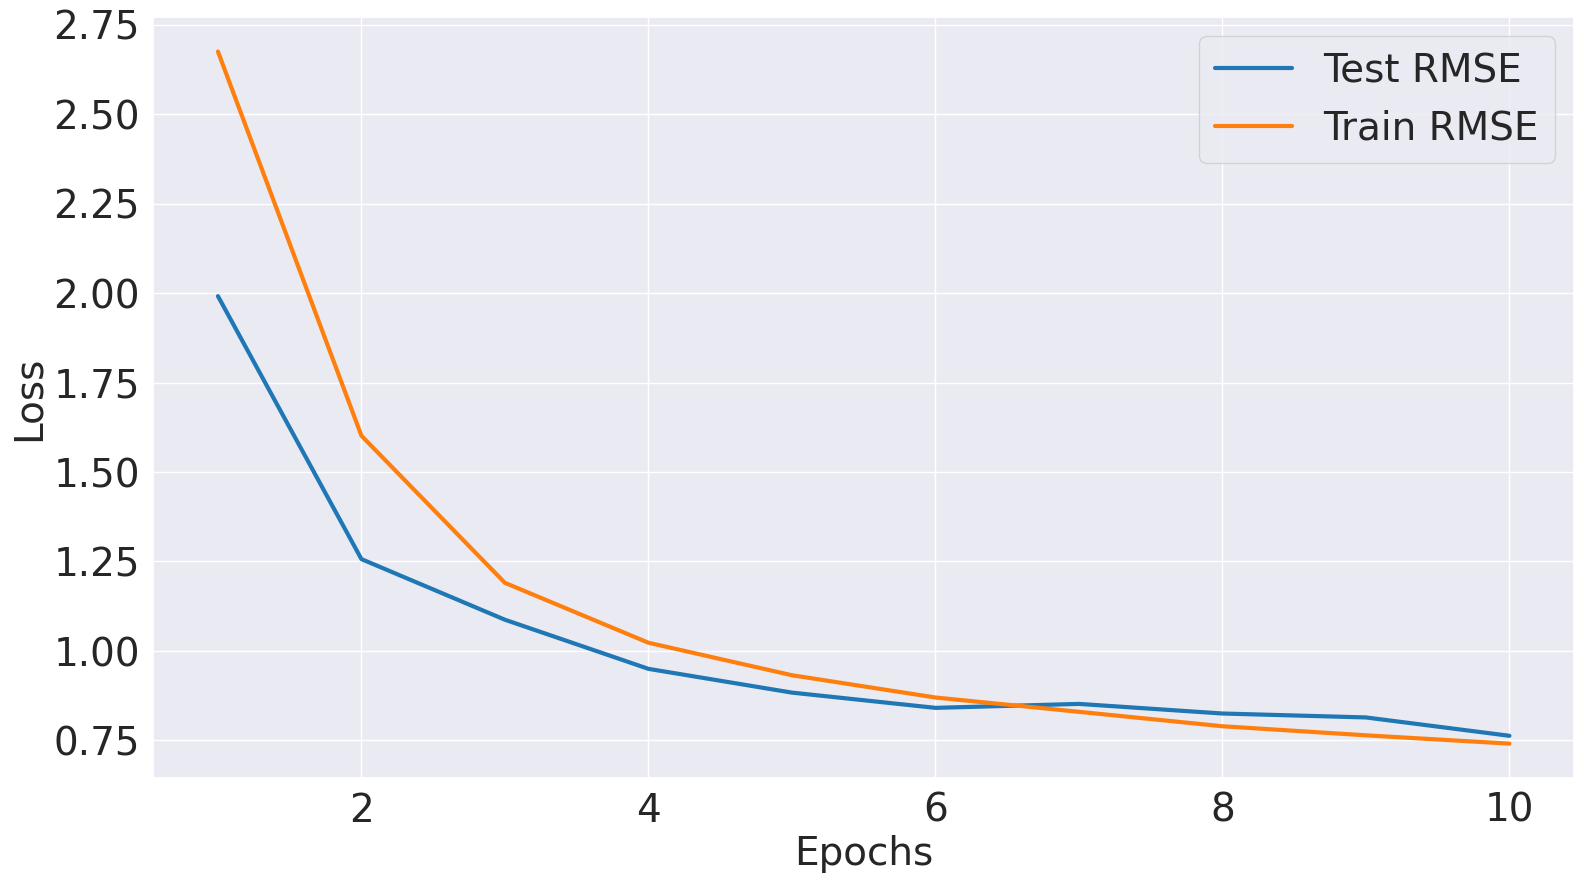

In [8]:
# Data/results directories
result_tag = 'combined'
data_dir = './data/split_processed_dms'
results_dir = './run_results/esm-blstm/notebook'

# Create run directory for results
now = datetime.datetime.now()
date_hour_minute = now.strftime("%Y-%m-%d_%H-%M")
run_dir = os.path.join(results_dir, f"esm_blstm-dms_{result_tag}-{date_hour_minute}")
os.makedirs(run_dir, exist_ok = True)

# Run setup
n_epochs = 10
batch_size = 32
max_batch = -1
num_workers = 64
lr = 1e-5
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# Create Dataset and DataLoader
torch.manual_seed(0)
dms_train_csv = os.path.join(data_dir, 'mutation_combined_OLD-DMS_train.csv') 
dms_test_csv = os.path.join(data_dir, 'mutation_combined_OLD-DMS_test.csv') 

train_dataset = DMSDataset(dms_train_csv)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=num_workers, pin_memory=True)

test_dataset = DMSDataset(dms_test_csv)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=num_workers, pin_memory=True)

# ESM input
esm = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D").to(device)
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

# BLSTM input
lstm_input_size = 320
lstm_hidden_size = 320
lstm_num_layers = 1        
lstm_bidrectional = True   
fcn_hidden_size = 320
blstm = BLSTM(lstm_input_size, lstm_hidden_size, lstm_num_layers, lstm_bidrectional, fcn_hidden_size)

model = ESM_BLSTM(esm, blstm)

# Run
count_parameters(model)
saved_model_pth = None
continue_from_checkpoint = False     
save_as = f"esm_blstm-dms_{result_tag}-train_{len(train_dataset)}_test_{len(test_dataset)}"
run_model(model, tokenizer, train_data_loader, test_data_loader, n_epochs, lr, max_batch, device, run_dir, save_as, saved_model_pth, continue_from_checkpoint) 

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


+---------------------------------------------------+------------+
|                      Modules                      | Parameters |
+---------------------------------------------------+------------+
|       esm.embeddings.word_embeddings.weight       |   10560    |
|     esm.embeddings.position_embeddings.weight     |   328320   |
|  esm.encoder.layer.0.attention.self.query.weight  |   102400   |
|   esm.encoder.layer.0.attention.self.query.bias   |    320     |
|   esm.encoder.layer.0.attention.self.key.weight   |   102400   |
|    esm.encoder.layer.0.attention.self.key.bias    |    320     |
|  esm.encoder.layer.0.attention.self.value.weight  |   102400   |
|   esm.encoder.layer.0.attention.self.value.bias   |    320     |
| esm.encoder.layer.0.attention.output.dense.weight |   102400   |
|  esm.encoder.layer.0.attention.output.dense.bias  |    320     |
|   esm.encoder.layer.0.attention.LayerNorm.weight  |    320     |
|    esm.encoder.layer.0.attention.LayerNorm.bias   |    320  

Epoch_test: 11: 100%|| 643/643 [00:17<00:00, 35.78it/s]


Epoch 11 | Train Binding MSE: 0.3357, Train Expression MSE: 0.1844, Train MSE: 0.5201
           Train Binding RMSE: 0.5794, Train Expression RMSE: 0.4294, Train RMSE: 0.7212
           Test Binding MSE: 0.3914, Test Expression MSE: 0.1771, Test MSE: 0.5685
           Test Binding RMSE: 0.6257, Test Expression RMSE: 0.4208, Test RMSE: 0.7540
NEW BEST model: loss 0.7540
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-57/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-57/checkpoint_saved_model.pth



Epoch_test: 12: 100%|| 643/643 [00:17<00:00, 35.86it/s]


Epoch 12 | Train Binding MSE: 0.3218, Train Expression MSE: 0.1761, Train MSE: 0.4979
           Train Binding RMSE: 0.5673, Train Expression RMSE: 0.4197, Train RMSE: 0.7056
           Test Binding MSE: 0.3860, Test Expression MSE: 0.1722, Test MSE: 0.5582
           Test Binding RMSE: 0.6213, Test Expression RMSE: 0.4149, Test RMSE: 0.7471
NEW BEST model: loss 0.7471
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-57/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-57/checkpoint_saved_model.pth



Epoch_test: 13: 100%|| 643/643 [00:18<00:00, 35.30it/s]


Epoch 13 | Train Binding MSE: 0.3051, Train Expression MSE: 0.1685, Train MSE: 0.4736
           Train Binding RMSE: 0.5524, Train Expression RMSE: 0.4104, Train RMSE: 0.6882
           Test Binding MSE: 0.3729, Test Expression MSE: 0.1716, Test MSE: 0.5445
           Test Binding RMSE: 0.6106, Test Expression RMSE: 0.4143, Test RMSE: 0.7379
NEW BEST model: loss 0.7379
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-57/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-57/checkpoint_saved_model.pth



Epoch_test: 14: 100%|| 643/643 [00:18<00:00, 35.22it/s]


Epoch 14 | Train Binding MSE: 0.2958, Train Expression MSE: 0.1636, Train MSE: 0.4594
           Train Binding RMSE: 0.5438, Train Expression RMSE: 0.4045, Train RMSE: 0.6778
           Test Binding MSE: 0.4139, Test Expression MSE: 0.1702, Test MSE: 0.5840
           Test Binding RMSE: 0.6433, Test Expression RMSE: 0.4125, Test RMSE: 0.7642
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-57/checkpoint_saved_model.pth



Epoch_test: 15: 100%|| 643/643 [00:18<00:00, 35.53it/s]


Epoch 15 | Train Binding MSE: 0.2817, Train Expression MSE: 0.1576, Train MSE: 0.4393
           Train Binding RMSE: 0.5308, Train Expression RMSE: 0.3970, Train RMSE: 0.6628
           Test Binding MSE: 0.3621, Test Expression MSE: 0.1552, Test MSE: 0.5172
           Test Binding RMSE: 0.6017, Test Expression RMSE: 0.3939, Test RMSE: 0.7192
NEW BEST model: loss 0.7192
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-57/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-57/checkpoint_saved_model.pth



Epoch_test: 16: 100%|| 643/643 [00:18<00:00, 35.47it/s]


Epoch 16 | Train Binding MSE: 0.2732, Train Expression MSE: 0.1525, Train MSE: 0.4257
           Train Binding RMSE: 0.5227, Train Expression RMSE: 0.3905, Train RMSE: 0.6525
           Test Binding MSE: 0.3505, Test Expression MSE: 0.1570, Test MSE: 0.5075
           Test Binding RMSE: 0.5920, Test Expression RMSE: 0.3963, Test RMSE: 0.7124
NEW BEST model: loss 0.7124
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-57/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-57/checkpoint_saved_model.pth



Epoch_test: 17: 100%|| 643/643 [00:18<00:00, 35.65it/s]


Epoch 17 | Train Binding MSE: 0.2644, Train Expression MSE: 0.1488, Train MSE: 0.4132
           Train Binding RMSE: 0.5142, Train Expression RMSE: 0.3857, Train RMSE: 0.6428
           Test Binding MSE: 0.3483, Test Expression MSE: 0.1515, Test MSE: 0.4998
           Test Binding RMSE: 0.5902, Test Expression RMSE: 0.3893, Test RMSE: 0.7070
NEW BEST model: loss 0.7070
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-57/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-57/checkpoint_saved_model.pth



Epoch_test: 18: 100%|| 643/643 [00:17<00:00, 35.96it/s]


Epoch 18 | Train Binding MSE: 0.2521, Train Expression MSE: 0.1432, Train MSE: 0.3953
           Train Binding RMSE: 0.5021, Train Expression RMSE: 0.3784, Train RMSE: 0.6287
           Test Binding MSE: 0.3425, Test Expression MSE: 0.1569, Test MSE: 0.4994
           Test Binding RMSE: 0.5852, Test Expression RMSE: 0.3961, Test RMSE: 0.7067
NEW BEST model: loss 0.7067
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-57/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-57/checkpoint_saved_model.pth



Epoch_test: 19: 100%|| 643/643 [00:18<00:00, 35.52it/s]


Epoch 19 | Train Binding MSE: 0.2445, Train Expression MSE: 0.1402, Train MSE: 0.3847
           Train Binding RMSE: 0.4945, Train Expression RMSE: 0.3744, Train RMSE: 0.6203
           Test Binding MSE: 0.3652, Test Expression MSE: 0.1470, Test MSE: 0.5122
           Test Binding RMSE: 0.6043, Test Expression RMSE: 0.3834, Test RMSE: 0.7157
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-57/checkpoint_saved_model.pth



Epoch_test: 20: 100%|| 643/643 [00:18<00:00, 35.60it/s]


Epoch 20 | Train Binding MSE: 0.2365, Train Expression MSE: 0.1368, Train MSE: 0.3732
           Train Binding RMSE: 0.4863, Train Expression RMSE: 0.3698, Train RMSE: 0.6109
           Test Binding MSE: 0.3578, Test Expression MSE: 0.1630, Test MSE: 0.5208
           Test Binding RMSE: 0.5982, Test Expression RMSE: 0.4037, Test RMSE: 0.7217
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-57/checkpoint_saved_model.pth

Training and testing complete in 1903.72 seconds.


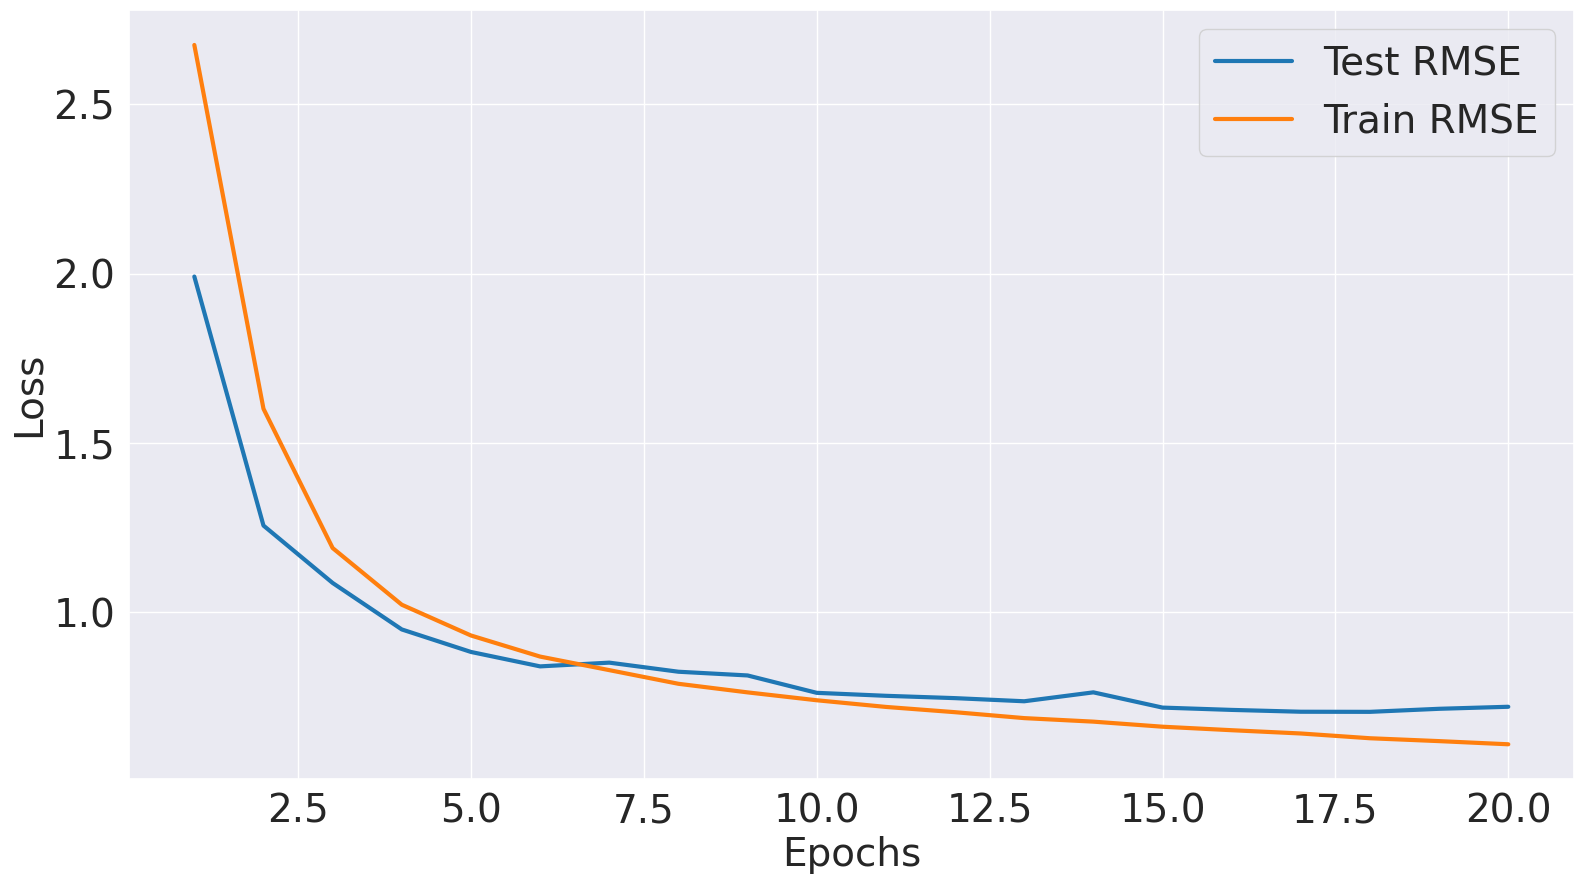

In [10]:
# Data/results directories
result_tag = 'combined'
data_dir = './data/split_processed_dms'
results_dir = './run_results/esm-blstm/notebook'

# Create run directory for results
now = datetime.datetime.now()
date_hour_minute = now.strftime("%Y-%m-%d_%H-%M")
run_dir = os.path.join(results_dir, f"esm_blstm-dms_{result_tag}-{date_hour_minute}")
os.makedirs(run_dir, exist_ok = True)

# Run setup
n_epochs = 20
batch_size = 32
max_batch = -1
num_workers = 64
lr = 1e-5
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# Create Dataset and DataLoader
torch.manual_seed(0)
dms_train_csv = os.path.join(data_dir, 'mutation_combined_OLD-DMS_train.csv') 
dms_test_csv = os.path.join(data_dir, 'mutation_combined_OLD-DMS_test.csv') 

train_dataset = DMSDataset(dms_train_csv)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=num_workers, pin_memory=True)

test_dataset = DMSDataset(dms_test_csv)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=num_workers, pin_memory=True)

# ESM input
esm = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D").to(device)
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

# BLSTM input
lstm_input_size = 320
lstm_hidden_size = 320
lstm_num_layers = 1        
lstm_bidrectional = True   
fcn_hidden_size = 320
blstm = BLSTM(lstm_input_size, lstm_hidden_size, lstm_num_layers, lstm_bidrectional, fcn_hidden_size)

model = ESM_BLSTM(esm, blstm)

# Run
count_parameters(model)
saved_model_pth = "./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-11/checkpoint_saved_model.pth" # saved weights from above
continue_from_checkpoint = True     
save_as = f"esm_blstm-dms_{result_tag}-train_{len(train_dataset)}_test_{len(test_dataset)}"
run_model(model, tokenizer, train_data_loader, test_data_loader, n_epochs, lr, max_batch, device, run_dir, save_as, saved_model_pth, continue_from_checkpoint)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


+---------------------------------------------------+------------+
|                      Modules                      | Parameters |
+---------------------------------------------------+------------+
|       esm.embeddings.word_embeddings.weight       |   10560    |
|     esm.embeddings.position_embeddings.weight     |   328320   |
|  esm.encoder.layer.0.attention.self.query.weight  |   102400   |
|   esm.encoder.layer.0.attention.self.query.bias   |    320     |
|   esm.encoder.layer.0.attention.self.key.weight   |   102400   |
|    esm.encoder.layer.0.attention.self.key.bias    |    320     |
|  esm.encoder.layer.0.attention.self.value.weight  |   102400   |
|   esm.encoder.layer.0.attention.self.value.bias   |    320     |
| esm.encoder.layer.0.attention.output.dense.weight |   102400   |
|  esm.encoder.layer.0.attention.output.dense.bias  |    320     |
|   esm.encoder.layer.0.attention.LayerNorm.weight  |    320     |
|    esm.encoder.layer.0.attention.LayerNorm.bias   |    320  

Epoch_test: 1:   3%|| 20/608 [00:00<00:17, 33.07it/s]


Epoch 1 | Train Binding MSE: 1.1669, Train Expression MSE: 0.5984, Train MSE: 1.7653
          Train Binding RMSE: 1.0802, Train Expression RMSE: 0.7736, Train RMSE: 1.3287
          Test Binding MSE: 0.8502, Test Expression MSE: 0.4197, Test MSE: 1.2698
          Test Binding RMSE: 0.9220, Test Expression RMSE: 0.6478, Test RMSE: 1.1269
NEW BEST model: loss 1.1269
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-01/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-01/checkpoint_saved_model.pth



Epoch_test: 2:   3%|| 20/608 [00:00<00:16, 34.91it/s]


Epoch 2 | Train Binding MSE: 0.9134, Train Expression MSE: 0.4851, Train MSE: 1.3985
          Train Binding RMSE: 0.9557, Train Expression RMSE: 0.6965, Train RMSE: 1.1826
          Test Binding MSE: 0.7040, Test Expression MSE: 0.3450, Test MSE: 1.0490
          Test Binding RMSE: 0.8391, Test Expression RMSE: 0.5873, Test RMSE: 1.0242
NEW BEST model: loss 1.0242
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-01/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-01/checkpoint_saved_model.pth



Epoch_test: 3:   3%|| 20/608 [00:00<00:16, 34.72it/s]


Epoch 3 | Train Binding MSE: 0.7674, Train Expression MSE: 0.3339, Train MSE: 1.1013
          Train Binding RMSE: 0.8760, Train Expression RMSE: 0.5778, Train RMSE: 1.0494
          Test Binding MSE: 0.6612, Test Expression MSE: 0.3690, Test MSE: 1.0301
          Test Binding RMSE: 0.8131, Test Expression RMSE: 0.6074, Test RMSE: 1.0150
NEW BEST model: loss 1.0150
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-01/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-01/checkpoint_saved_model.pth



Epoch_test: 4:   3%|| 20/608 [00:00<00:16, 34.93it/s]


Epoch 4 | Train Binding MSE: 0.6580, Train Expression MSE: 0.3483, Train MSE: 1.0063
          Train Binding RMSE: 0.8112, Train Expression RMSE: 0.5902, Train RMSE: 1.0031
          Test Binding MSE: 0.6196, Test Expression MSE: 0.3210, Test MSE: 0.9406
          Test Binding RMSE: 0.7871, Test Expression RMSE: 0.5666, Test RMSE: 0.9699
NEW BEST model: loss 0.9699
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-01/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-01/checkpoint_saved_model.pth



Epoch_test: 5:   3%|| 20/608 [00:00<00:16, 35.09it/s]


Epoch 5 | Train Binding MSE: 0.6617, Train Expression MSE: 0.3384, Train MSE: 1.0001
          Train Binding RMSE: 0.8134, Train Expression RMSE: 0.5818, Train RMSE: 1.0001
          Test Binding MSE: 0.7542, Test Expression MSE: 0.3620, Test MSE: 1.1163
          Test Binding RMSE: 0.8685, Test Expression RMSE: 0.6017, Test RMSE: 1.0565
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-01/checkpoint_saved_model.pth



Epoch_test: 6:   3%|| 20/608 [00:00<00:16, 35.18it/s]


Epoch 6 | Train Binding MSE: 0.7087, Train Expression MSE: 0.3579, Train MSE: 1.0665
          Train Binding RMSE: 0.8418, Train Expression RMSE: 0.5982, Train RMSE: 1.0327
          Test Binding MSE: 0.6449, Test Expression MSE: 0.3497, Test MSE: 0.9947
          Test Binding RMSE: 0.8031, Test Expression RMSE: 0.5914, Test RMSE: 0.9973
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-01/checkpoint_saved_model.pth



Epoch_test: 7:   3%|| 20/608 [00:00<00:17, 34.29it/s]


Epoch 7 | Train Binding MSE: 0.6324, Train Expression MSE: 0.3524, Train MSE: 0.9848
          Train Binding RMSE: 0.7952, Train Expression RMSE: 0.5936, Train RMSE: 0.9924
          Test Binding MSE: 0.5612, Test Expression MSE: 0.3065, Test MSE: 0.8677
          Test Binding RMSE: 0.7492, Test Expression RMSE: 0.5536, Test RMSE: 0.9315
NEW BEST model: loss 0.9315
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-01/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-01/checkpoint_saved_model.pth



Epoch_test: 8:   3%|| 20/608 [00:00<00:16, 34.70it/s]


Epoch 8 | Train Binding MSE: 0.6305, Train Expression MSE: 0.3128, Train MSE: 0.9433
          Train Binding RMSE: 0.7940, Train Expression RMSE: 0.5593, Train RMSE: 0.9713
          Test Binding MSE: 0.6681, Test Expression MSE: 0.3617, Test MSE: 1.0298
          Test Binding RMSE: 0.8174, Test Expression RMSE: 0.6014, Test RMSE: 1.0148
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-01/checkpoint_saved_model.pth



Epoch_test: 9:   3%|| 20/608 [00:00<00:16, 34.84it/s]


Epoch 9 | Train Binding MSE: 0.6989, Train Expression MSE: 0.3535, Train MSE: 1.0524
          Train Binding RMSE: 0.8360, Train Expression RMSE: 0.5945, Train RMSE: 1.0259
          Test Binding MSE: 0.5472, Test Expression MSE: 0.3413, Test MSE: 0.8885
          Test Binding RMSE: 0.7398, Test Expression RMSE: 0.5842, Test RMSE: 0.9426
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-01/checkpoint_saved_model.pth



Epoch_test: 10:   3%|| 20/608 [00:00<00:17, 33.73it/s]


Epoch 10 | Train Binding MSE: 0.6441, Train Expression MSE: 0.3432, Train MSE: 0.9873
           Train Binding RMSE: 0.8026, Train Expression RMSE: 0.5858, Train RMSE: 0.9937
           Test Binding MSE: 0.6125, Test Expression MSE: 0.3197, Test MSE: 0.9322
           Test Binding RMSE: 0.7826, Test Expression RMSE: 0.5654, Test RMSE: 0.9655
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-01/checkpoint_saved_model.pth

Training and testing complete in 54.62 seconds.


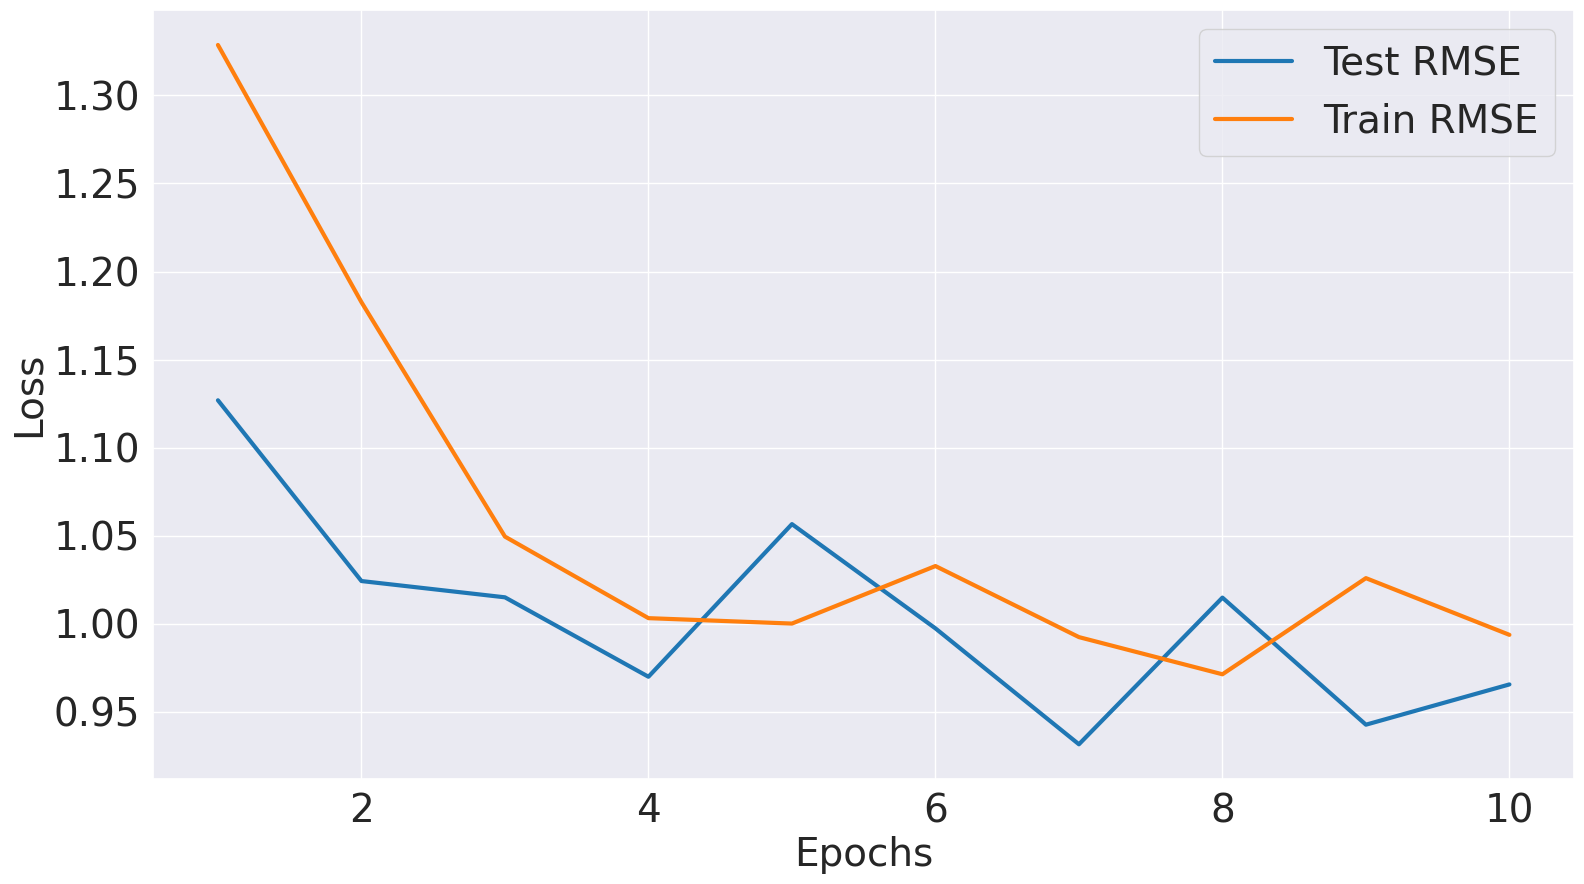

In [12]:
# Data/results directories
result_tag = 'combined'
data_dir = './data/split_processed_dms'
results_dir = './run_results/esm-blstm/notebook'

# Create run directory for results
now = datetime.datetime.now()
date_hour_minute = now.strftime("%Y-%m-%d_%H-%M")
run_dir = os.path.join(results_dir, f"esm_blstm-dms_{result_tag}-{date_hour_minute}")
os.makedirs(run_dir, exist_ok = True)

# Run setup
n_epochs = 10
batch_size = 32
max_batch = 20
num_workers = 64
lr = 1e-5
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# Create Dataset and DataLoader
torch.manual_seed(0)
dms_train_csv = os.path.join(data_dir, 'mutation_combined_NEW-DMS_train.csv') 
dms_test_csv = os.path.join(data_dir, 'mutation_combined_NEW-DMS_test.csv') 

train_dataset = DMSDataset(dms_train_csv)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=num_workers, pin_memory=True)

test_dataset = DMSDataset(dms_test_csv)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=num_workers, pin_memory=True)

# ESM input
esm = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D").to(device)
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

# BLSTM input
lstm_input_size = 320
lstm_hidden_size = 320
lstm_num_layers = 1        
lstm_bidrectional = True   
fcn_hidden_size = 320
blstm = BLSTM(lstm_input_size, lstm_hidden_size, lstm_num_layers, lstm_bidrectional, fcn_hidden_size)

model = ESM_BLSTM(esm, blstm)

# Run
count_parameters(model)
saved_model_pth = "./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-01_23-57/checkpoint_saved_model.pth" # saved weights from above
continue_from_checkpoint = False     
save_as = f"esm_blstm-dms_{result_tag}-train_{len(train_dataset)}_test_{len(test_dataset)}"
run_model(model, tokenizer, train_data_loader, test_data_loader, n_epochs, lr, max_batch, device, run_dir, save_as, saved_model_pth, continue_from_checkpoint)

Don't worry that the plots and data don't look so great. There is a lot of training that needs to be done...

---
### Loading in saved weights from 2 models into both heads:
I'm not going to adjust the new load function we now have, this is more a matter of proof of concept whether we can do this or not. But, we should be able to load previously trained model weights into both of the heads separately. We'll run the full dataset this time.

In [14]:
def load_model_into_heads(model, binding_model_pth, expression_model_pth, device):
    # Load the binding head model
    binding_state = torch.load(binding_model_pth, map_location=device)
    binding_state_dict = binding_state['model_state_dict']
    
    # Load the expression head model
    expression_state = torch.load(expression_model_pth, map_location=device)
    expression_state_dict = expression_state['model_state_dict']
    
    # Load ESM model layers from one of the checkpoints
    esm_layers = {k: v for k, v in binding_state_dict.items() if re.search(r'\besm\b', k)}
    model.esm.load_state_dict(esm_layers, strict=False)
    
    # Load BLSTM shared layers from one of the checkpoints 
    blstm_shared_layers = {k: v for k, v in binding_state_dict.items() if re.search(r'\bblstm\b', k) and 'out' not in k}
    model.blstm.load_state_dict(blstm_shared_layers, strict=False)
    
    # Load the binding head weights
    binding_weight_key = next((k for k in binding_state_dict.keys() if re.search(r'out\.weight$', k)), None)
    binding_bias_key = next((k for k in binding_state_dict.keys() if re.search(r'out\.bias$', k)), None)
    
    if binding_weight_key and binding_bias_key:
        binding_head_weights = {
            'weight': binding_state_dict[binding_weight_key],
            'bias': binding_state_dict[binding_bias_key]
        }
        model.blstm.binding_head.load_state_dict(binding_head_weights)
        print(f"Loaded binding head from {binding_model_pth}")
    
    # Load the expression head weights
    expression_weight_key = next((k for k in expression_state_dict.keys() if re.search(r'out\.weight$', k)), None)
    expression_bias_key = next((k for k in expression_state_dict.keys() if re.search(r'out\.bias$', k)), None)
    
    if expression_weight_key and expression_bias_key:
        expression_head_weights = {
            'weight': expression_state_dict[expression_weight_key],
            'bias': expression_state_dict[expression_bias_key]
        }
        model.blstm.expression_head.load_state_dict(expression_head_weights)
        print(f"Loaded expression head from {expression_model_pth}")
    
    return model.to(device)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded binding head from ../results/run_results/esm-blstm/esm-blstm-esm_dms_binding-2023-12-12_17-02/esm-blstm-esm_dms_binding-2023-12-12_17-02_train_84420_test_21105.model_save
Loaded expression head from ../results/run_results/esm-blstm/esm-blstm-esm_dms_expression-2023-12-12_16-58/esm-blstm-esm_dms_expression-2023-12-12_16-58_train_93005_test_23252.model_save
+---------------------------------------------------+------------+
|                      Modules                      | Parameters |
+---------------------------------------------------+------------+
|       esm.embeddings.word_embeddings.weight       |   10560    |
|     esm.embeddings.position_embeddings.weight     |   328320   |
|  esm.encoder.layer.0.attention.self.query.weight  |   102400   |
|   esm.encoder.layer.0.attention.self.query.bias   |    320     |
|   esm.encoder.layer.0.attention.self.key.weight   |   102400   |
|    esm.encoder.layer.0.attention.self.key.bias    |    320     |
|  esm.encoder.layer.0.attention

Epoch_test: 1: 100%|| 608/608 [00:16<00:00, 36.07it/s]


Epoch 1 | Train Binding MSE: 2.7149, Train Expression MSE: 1.8832, Train MSE: 4.5981
          Train Binding RMSE: 1.6477, Train Expression RMSE: 1.3723, Train RMSE: 2.1443
          Test Binding MSE: 2.0576, Test Expression MSE: 1.2093, Test MSE: 3.2670
          Test Binding RMSE: 1.4344, Test Expression RMSE: 1.0997, Test RMSE: 1.8075
NEW BEST model: loss 1.8075
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-25/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-25/checkpoint_saved_model.pth



Epoch_test: 2: 100%|| 608/608 [00:17<00:00, 35.54it/s]


Epoch 2 | Train Binding MSE: 1.8047, Train Expression MSE: 1.1268, Train MSE: 2.9315
          Train Binding RMSE: 1.3434, Train Expression RMSE: 1.0615, Train RMSE: 1.7122
          Test Binding MSE: 1.2922, Test Expression MSE: 0.8176, Test MSE: 2.1098
          Test Binding RMSE: 1.1368, Test Expression RMSE: 0.9042, Test RMSE: 1.4525
NEW BEST model: loss 1.4525
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-25/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-25/checkpoint_saved_model.pth



Epoch_test: 3: 100%|| 608/608 [00:17<00:00, 35.21it/s]


Epoch 3 | Train Binding MSE: 1.1970, Train Expression MSE: 0.7726, Train MSE: 1.9696
          Train Binding RMSE: 1.0941, Train Expression RMSE: 0.8790, Train RMSE: 1.4034
          Test Binding MSE: 0.8686, Test Expression MSE: 0.5594, Test MSE: 1.4280
          Test Binding RMSE: 0.9320, Test Expression RMSE: 0.7479, Test RMSE: 1.1950
NEW BEST model: loss 1.1950
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-25/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-25/checkpoint_saved_model.pth



Epoch_test: 4: 100%|| 608/608 [00:17<00:00, 35.37it/s]


Epoch 4 | Train Binding MSE: 0.7610, Train Expression MSE: 0.5251, Train MSE: 1.2861
          Train Binding RMSE: 0.8724, Train Expression RMSE: 0.7246, Train RMSE: 1.1341
          Test Binding MSE: 0.7075, Test Expression MSE: 0.4615, Test MSE: 1.1689
          Test Binding RMSE: 0.8411, Test Expression RMSE: 0.6793, Test RMSE: 1.0812
NEW BEST model: loss 1.0812
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-25/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-25/checkpoint_saved_model.pth



Epoch_test: 5: 100%|| 608/608 [00:17<00:00, 35.32it/s]


Epoch 5 | Train Binding MSE: 0.6205, Train Expression MSE: 0.4235, Train MSE: 1.0440
          Train Binding RMSE: 0.7877, Train Expression RMSE: 0.6508, Train RMSE: 1.0218
          Test Binding MSE: 0.5909, Test Expression MSE: 0.3908, Test MSE: 0.9817
          Test Binding RMSE: 0.7687, Test Expression RMSE: 0.6251, Test RMSE: 0.9908
NEW BEST model: loss 0.9908
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-25/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-25/checkpoint_saved_model.pth



Epoch_test: 6: 100%|| 608/608 [00:16<00:00, 35.85it/s]


Epoch 6 | Train Binding MSE: 0.5466, Train Expression MSE: 0.3635, Train MSE: 0.9101
          Train Binding RMSE: 0.7393, Train Expression RMSE: 0.6029, Train RMSE: 0.9540
          Test Binding MSE: 0.5405, Test Expression MSE: 0.3476, Test MSE: 0.8881
          Test Binding RMSE: 0.7352, Test Expression RMSE: 0.5896, Test RMSE: 0.9424
NEW BEST model: loss 0.9424
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-25/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-25/checkpoint_saved_model.pth



Epoch_test: 7: 100%|| 608/608 [00:17<00:00, 35.04it/s]


Epoch 7 | Train Binding MSE: 0.5019, Train Expression MSE: 0.3274, Train MSE: 0.8293
          Train Binding RMSE: 0.7085, Train Expression RMSE: 0.5722, Train RMSE: 0.9107
          Test Binding MSE: 0.5348, Test Expression MSE: 0.3302, Test MSE: 0.8649
          Test Binding RMSE: 0.7313, Test Expression RMSE: 0.5746, Test RMSE: 0.9300
NEW BEST model: loss 0.9300
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-25/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-25/checkpoint_saved_model.pth



Epoch_test: 8: 100%|| 608/608 [00:17<00:00, 35.50it/s]


Epoch 8 | Train Binding MSE: 0.4713, Train Expression MSE: 0.3030, Train MSE: 0.7743
          Train Binding RMSE: 0.6865, Train Expression RMSE: 0.5504, Train RMSE: 0.8799
          Test Binding MSE: 0.4634, Test Expression MSE: 0.2882, Test MSE: 0.7516
          Test Binding RMSE: 0.6808, Test Expression RMSE: 0.5368, Test RMSE: 0.8670
NEW BEST model: loss 0.8670
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-25/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-25/checkpoint_saved_model.pth



Epoch_test: 9: 100%|| 608/608 [00:17<00:00, 35.01it/s]


Epoch 9 | Train Binding MSE: 0.4490, Train Expression MSE: 0.2814, Train MSE: 0.7304
          Train Binding RMSE: 0.6701, Train Expression RMSE: 0.5305, Train RMSE: 0.8547
          Test Binding MSE: 0.4504, Test Expression MSE: 0.2715, Test MSE: 0.7219
          Test Binding RMSE: 0.6711, Test Expression RMSE: 0.5210, Test RMSE: 0.8496
NEW BEST model: loss 0.8496
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-25/best_saved_model.pth
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-25/checkpoint_saved_model.pth



Epoch_test: 10: 100%|| 608/608 [00:17<00:00, 35.05it/s]


Epoch 10 | Train Binding MSE: 0.4314, Train Expression MSE: 0.2641, Train MSE: 0.6955
           Train Binding RMSE: 0.6568, Train Expression RMSE: 0.5139, Train RMSE: 0.8339
           Test Binding MSE: 0.4625, Test Expression MSE: 0.3112, Test MSE: 0.7737
           Test Binding RMSE: 0.6801, Test Expression RMSE: 0.5579, Test RMSE: 0.8796
Model and optimizer state saved to ./run_results/esm-blstm/notebook/esm_blstm-dms_combined-2024-09-02_01-25/checkpoint_saved_model.pth

Training and testing complete in 1805.01 seconds.


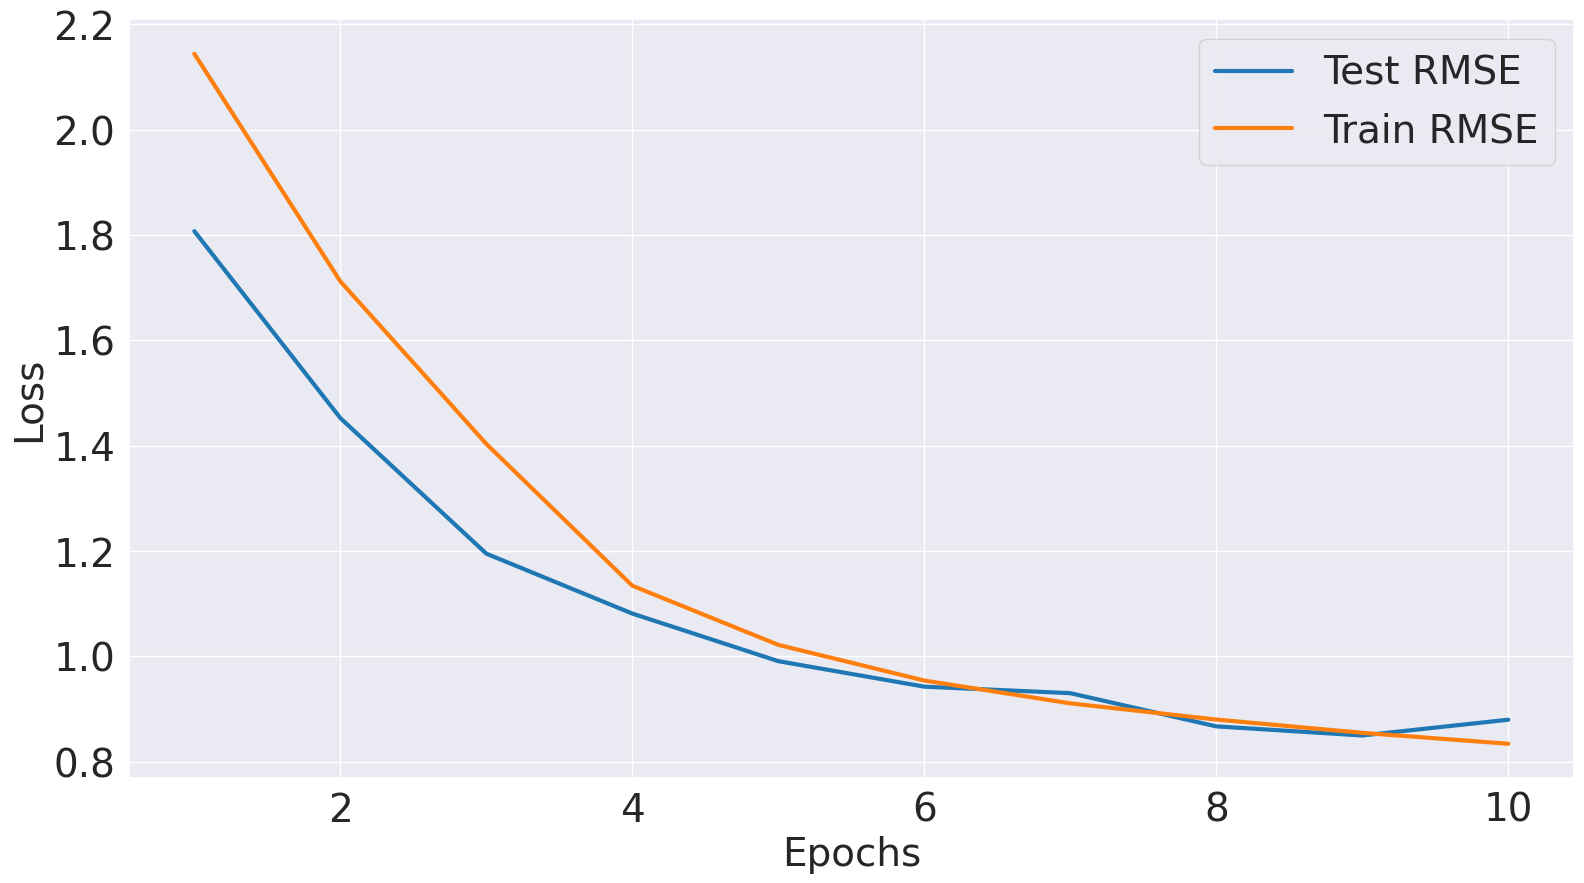

In [15]:
# Data/results directories
result_tag = 'combined'
old_data_dir = '../results/run_results/esm-blstm'
data_dir = './data/split_processed_dms'
results_dir = './run_results/esm-blstm/notebook'

# Create run directory for results
now = datetime.datetime.now()
date_hour_minute = now.strftime("%Y-%m-%d_%H-%M")
run_dir = os.path.join(results_dir, f"esm_blstm-dms_{result_tag}-{date_hour_minute}")
os.makedirs(run_dir, exist_ok = True)

# Run setup
n_epochs = 10
batch_size = 32
max_batch = -1
num_workers = 64
lr = 1e-5
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# Create Dataset and DataLoader
torch.manual_seed(0)
dms_train_csv = os.path.join(data_dir, 'mutation_combined_NEW-DMS_train.csv') 
dms_test_csv = os.path.join(data_dir, 'mutation_combined_NEW-DMS_test.csv') 

train_dataset = DMSDataset(dms_train_csv)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=num_workers, pin_memory=True)

test_dataset = DMSDataset(dms_test_csv)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=num_workers, pin_memory=True)

# ESM input
esm = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D").to(device)
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

# BLSTM input
lstm_input_size = 320
lstm_hidden_size = 320
lstm_num_layers = 1        
lstm_bidrectional = True   
fcn_hidden_size = 320
blstm = BLSTM(lstm_input_size, lstm_hidden_size, lstm_num_layers, lstm_bidrectional, fcn_hidden_size)

model = ESM_BLSTM(esm, blstm)

# Loading saved model weights into heads
binding_trained_model_pth = os.path.join(old_data_dir, "esm-blstm-esm_dms_binding-2023-12-12_17-02/esm-blstm-esm_dms_binding-2023-12-12_17-02_train_84420_test_21105.model_save")
expression_trained_model_pth = os.path.join(old_data_dir, "esm-blstm-esm_dms_expression-2023-12-12_16-58/esm-blstm-esm_dms_expression-2023-12-12_16-58_train_93005_test_23252.model_save")
load_model_into_heads(model, binding_trained_model_pth, expression_trained_model_pth, device)

# Run
count_parameters(model)
saved_model_pth = None
continue_from_checkpoint = False
save_as = f"esm_blstm-dms_{result_tag}-train_{len(train_dataset)}_test_{len(test_dataset)}"
run_model(model, tokenizer, train_data_loader, test_data_loader, n_epochs, lr, max_batch, device, run_dir, save_as, saved_model_pth, continue_from_checkpoint)